In [1]:
import h5py
import torch
import random
import numpy as np
import pandas as pd
import torchmetrics
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

import cv2
import torch
from torchvision.transforms import ToTensor
from torch_staintools.normalizer import NormalizerBuilder
from torch_staintools.augmentor import AugmentorBuilder
from DLMI_histopathology.dataset import BaselineDataset
import torch.nn as nn

from StainNet.models import StainNet, ResnetGenerator

In [2]:
TRAIN_IMAGES_PATH = 'train.h5'
VAL_IMAGES_PATH = 'val.h5'
TEST_IMAGES_PATH = 'test.h5'
SEED = 0
torch.random.manual_seed(SEED)
random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Working on {device}.')

Working on cuda.


# Step 1 : Search for the best image of the best center

In [3]:
centers={}
with h5py.File(TRAIN_IMAGES_PATH, 'r') as hdf:    
    idx_train=list(hdf.keys())
    for indexes in idx_train:
        centers_nb=int(hdf.get(indexes).get("metadata")[0])
        if centers_nb not in centers:
            centers[centers_nb]=1
        else:
            centers[centers_nb]+=1

In [4]:
centers

{3: 38756, 4: 43488, 0: 17756}

Center 4 has the most images, we will adapt the staining of this center to the other center

# Step 2 : Get the most relevant image

In [5]:
class BaselineDatasetCenter(Dataset):
    def __init__(self, dataset_path, preprocessing, mode,center):
        super(BaselineDatasetCenter, self).__init__()
        self.dataset_path = dataset_path
        self.preprocessing = preprocessing
        self.mode = mode
        self.image_ids=[]
        with h5py.File(self.dataset_path, 'r') as hdf:        
            indx = np.array(list(hdf.keys()))
            for indexes in indx:
                centers_nb=int(hdf.get(indexes).get("metadata")[0])
                if centers_nb==center:
                    self.image_ids.append(indexes)


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        with h5py.File(self.dataset_path, 'r') as hdf:
            img = torch.tensor(np.array(hdf.get(img_id).get('img')))
            label = np.array(hdf.get(img_id).get('label')) if self.mode == 'train' else None
        return self.preprocessing(img).float(), label

In [6]:
preprocessing = transforms.Resize((98, 98))
train_set_3=BaselineDatasetCenter(TRAIN_IMAGES_PATH,preprocessing,"train",3)
train_set_4=BaselineDatasetCenter(TRAIN_IMAGES_PATH,preprocessing,"train",4)
train_set_0=BaselineDatasetCenter(TRAIN_IMAGES_PATH,preprocessing,"train",0)

In [7]:
train_loader_3=DataLoader(train_set_3,shuffle=False,batch_size=256)
train_loader_4=DataLoader(train_set_4,shuffle=False,batch_size=256)
train_loader_0=DataLoader(train_set_0,shuffle=False,batch_size=256)

In [8]:
def compute_stats(loader):
    mean=torch.zeros(3).to(device)
    std=torch.zeros(3).to(device)
    for data,lab in loader:
        mean+=torch.mean(data.to(device),dim=[0,2,3]).to(device)
        std+=torch.std(data.to(device),dim=[0,2,3]).to(device)   
    return mean/len(loader), std/len(loader)
compute_stats(train_loader_4)

(tensor([0.7997, 0.6722, 0.8196], device='cuda:0'),
 tensor([0.1200, 0.1492, 0.0916], device='cuda:0'))

We choose the image from the train set of the center 4 that is closest to the mean and std of this set

In [9]:
mean_center_4=torch.tensor([0.7997, 0.6722, 0.8196]).to(device)
std_center_4=torch.tensor([0.1200, 0.1492, 0.0916]).to(device)

mean_center_4,std_center_4=compute_stats(train_loader_4)

normalizer_macenko = NormalizerBuilder.build('macenko',concentration_method='ista').to(device)

def find_best_image(dataset):
    criterion=nn.MSELoss()
    best_loss=float("inf")
    best_img=None
    for img,_ in dataset:
        img=img.to(device)
        mean_img=torch.mean(img,dim=[1,2]).to(device)
        std_img=torch.std(img,dim=[1,2]).to(device)
        loss = criterion(mean_center_4,mean_img) + criterion(std_center_4,std_img)
    
        if loss.item() < best_loss:
            best_img=img
            best_loss=loss.item()
        
    return best_img
best_rep=find_best_image(train_set_4)

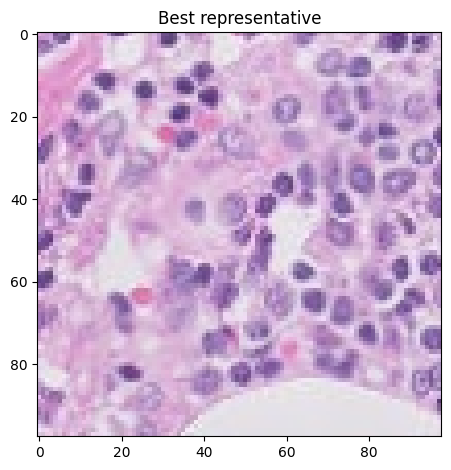

In [10]:
plt.imshow(np.moveaxis(best_rep.cpu().numpy(),0,-1))
plt.title("Best representative")
plt.tight_layout()

Once we find it, we fit the stain normalizer

In [15]:
normalizer_macenko.fit(best_rep.unsqueeze(0))

# Step 3 : Incorporate the stain normalization in the transform pipeline

In [28]:
mean = [0.7439, 0.5892, 0.7210] 
std = [0.1717, 0.2065, 0.1664]

def normalize_stain(batch):
    return normalizer_macenko.transform(batch.to(device).unsqueeze(0)).squeeze()

transform = transforms.Compose([
            transforms.Resize((98, 98)),
            #transforms.Normalize(mean=mean, std=std),
            normalize_stain
        ])

base_transform=transforms.Compose([
            transforms.Resize((98, 98)),
        ])

In [33]:
from DLMI_histopathology.dataset import BaselineDataset, PrecomputedDataset, AugmentedDataset, precompute

feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
feature_extractor.eval()

train_dataset=BaselineDataset(TRAIN_IMAGES_PATH, base_transform, 'train')
val_dataset=BaselineDataset(VAL_IMAGES_PATH, base_transform, 'train')

train_dataset_stained=BaselineDataset(TRAIN_IMAGES_PATH, transform, 'train')


val_dataset_stained=BaselineDataset(VAL_IMAGES_PATH, transform, 'train')
train_set_3_stained=BaselineDatasetCenter(TRAIN_IMAGES_PATH,transform,"train",3)
train_set_4_stained=BaselineDatasetCenter(TRAIN_IMAGES_PATH,transform,"train",4)
train_set_0_stained=BaselineDatasetCenter(TRAIN_IMAGES_PATH,transform,"train",0)



BATCH_SIZE=64

train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

feat_extr=nn.Sequential(model_Net,feature_extractor)

#precomputed_train_dataset = PrecomputedDataset(*precompute(train_dataloader, feat_extr, device))
#precomputed_val_dataset = PrecomputedDataset(*precompute(val_dataloader, feat_extr, device))


Using cache found in /raid/home/detectionfeuxdeforet/elyaalaoui_adi/.cache/torch/hub/facebookresearch_dinov2_main
INFO:dinov2:using MLP layer as FFN


## Visual comparison 

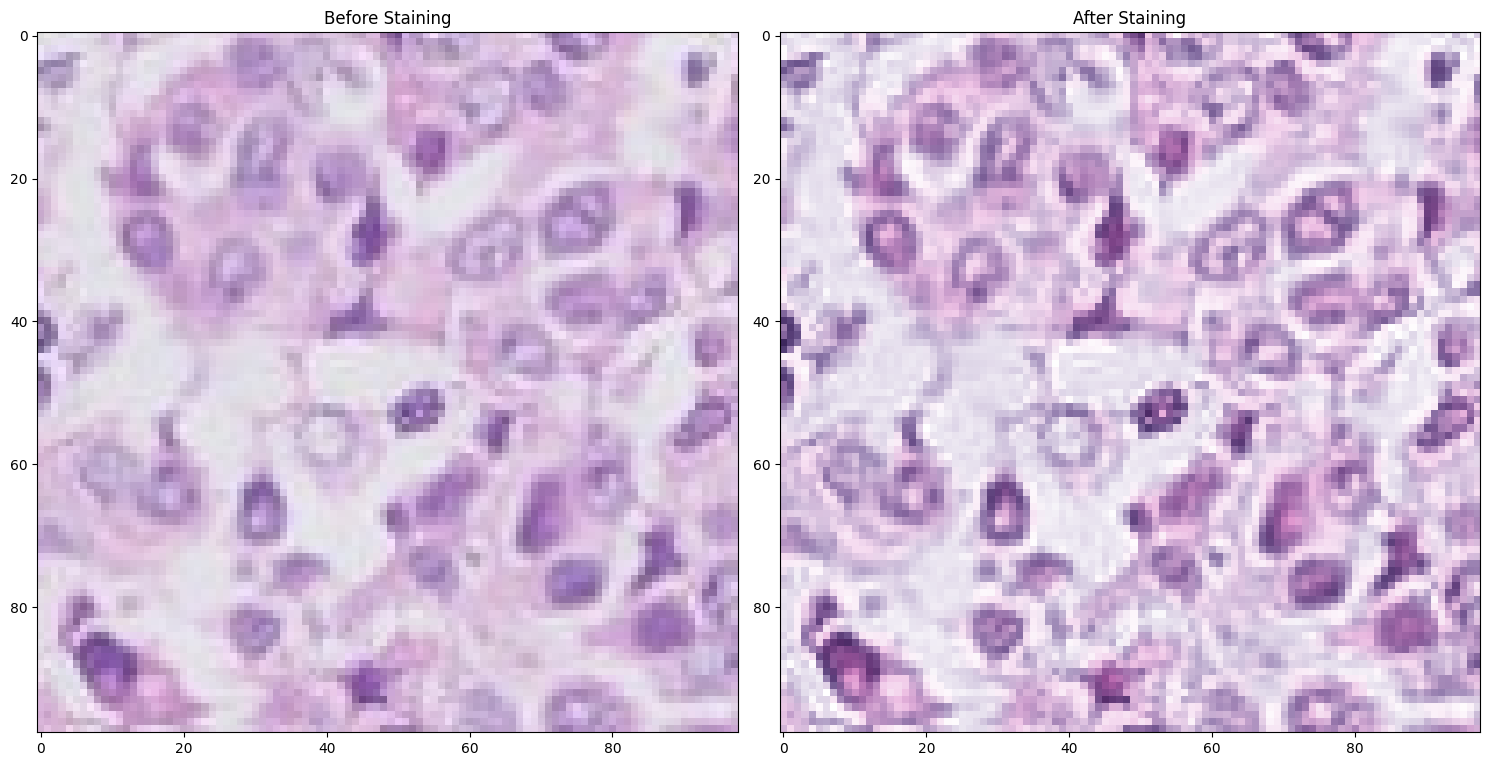

In [35]:
id=15
pre_stained=train_set_4[id][0]
post_stained=train_set_4_stained[id][0]
fig,ax=plt.subplots(1,2,figsize=(15,10))
ax[0].imshow(np.moveaxis(pre_stained.cpu().numpy(),0,-1))
ax[0].set_title("Before Staining")
ax[1].imshow(np.moveaxis(post_stained.cpu().numpy(),0,-1))
ax[1].set_title("After Staining")
fig.tight_layout()

# Step 4 : create a loader with the precomputed features from DinoV2 on the stained data

To run if the features are locally saved

In [4]:
from DLMI_histopathology.dataset import PrecomputedDataset
feats_train,lab_train=torch.load("precomp_stained_train.pt")["features"],torch.load("precomp_stained_train.pt")["labels"].squeeze()
feats_val,lab_val=torch.load("precomp_stained_val.pt")["features"],torch.load("precomp_stained_val.pt")["labels"].squeeze()
precomputed_train_dataset = PrecomputedDataset(feats_train,lab_train)
precomputed_val_dataset = PrecomputedDataset(feats_val,lab_val)

In [19]:
precomp_loader=DataLoader(precomputed_train_dataset,shuffle=True,batch_size=256)
precomp_val_loader=DataLoader(precomputed_val_dataset,shuffle=False,batch_size=256)

In [20]:
def train_model(model, train_dataloader, val_dataloader, device, optimizer_name='Adam', optimizer_params={'lr': 0.001}, 
                 loss_name='BCELoss', metric_name='Accuracy', num_epochs=100, patience=10, save_path='best_model.pth'):
    """
    Trains a PyTorch model with early stopping.
    
    Args:
        model: PyTorch model to train.
        train_dataloader: DataLoader for training data.
        val_dataloader: DataLoader for validation data.
        device: Device to run training on ('cuda' or 'cpu').
        optimizer_name: Name of the optimizer (e.g., 'Adam').
        optimizer_params: Dictionary of optimizer parameters.
        loss_name: Name of the loss function (e.g., 'BCELoss').
        metric_name: Name of the evaluation metric (e.g., 'Accuracy').
        num_epochs: Maximum number of training epochs.
        patience: Number of epochs to wait for improvement before stopping.
        save_path: Path to save the best model.
    """
    
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), **optimizer_params)
    criterion = getattr(torch.nn, loss_name)()
    metric = getattr(torchmetrics, metric_name)('binary')
    
    min_loss, best_epoch = float('inf'), 0
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        train_metrics, train_losses = [], []
        
        for train_x, train_y in tqdm(train_dataloader, leave=False):
            optimizer.zero_grad()
            train_pred = model(train_x.to(device))
            loss = criterion(train_pred, train_y.to(device))
            loss.backward()
            optimizer.step()
            
            train_losses.extend([loss.item()] * len(train_y))
            train_metric = metric(train_pred.cpu(), train_y.int().cpu())
            train_metrics.extend([train_metric.item()] * len(train_y))
        
        model.eval()
        val_metrics, val_losses = [], []
        
        for val_x, val_y in tqdm(val_dataloader, leave=False):
            with torch.no_grad():
                val_pred = model(val_x.to(device))
            loss = criterion(val_pred, val_y.to(device))
            
            val_losses.extend([loss.item()] * len(val_y))
            val_metric = metric(val_pred.cpu(), val_y.int().cpu())
            val_metrics.extend([val_metric.item()] * len(val_y))
        
        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {np.mean(train_losses):.4f} | Train Metric {np.mean(train_metrics):.4f} '
              f'Val Loss: {np.mean(val_losses):.4f} Val Metric {np.mean(val_metrics):.4f}')
        
        if np.mean(val_losses) < min_loss:
            mean_val_loss = np.mean(val_losses)
            print(f'New best loss {min_loss:.4f} -> {mean_val_loss:.4f}')
            min_loss = mean_val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), save_path)
        
        if epoch - best_epoch == patience:
            print(f"Model has not improved in val set for {patience} epochs. Stopping early.")
            break


In [21]:
from DLMI_histopathology.models import HistoClassifierHead, NewHistoClassifierHead
class HistoClassifierHead(nn.Module):

    def __init__(self, dim_input, hidden_dim, dropout):
        super().__init__()
        self.layer1 = nn.Linear(dim_input, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, 1)
        self.layernorm1 = nn.LayerNorm(dim_input)
        self.layernorm2 = nn.LayerNorm(hidden_dim)
        self.layernorm3 = nn.LayerNorm(hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self,x):
        x = self.relu(self.layer1(x))
        x = self.dropout(self.layernorm2(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        x = self.sigmoid(x) 

        return x 
    
model_prob = HistoClassifierHead(dim_input=384, hidden_dim=64, dropout=0.2)
model_prob.to(device)


HistoClassifierHead(
  (layer1): Linear(in_features=384, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (layernorm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (layernorm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (layernorm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [22]:
OPTIMIZER = 'AdamW'
OPTIMIZER_PARAMS = {'lr': 5e-4, 'weight_decay' : 0.02}
LOSS = 'BCELoss'
METRIC = 'Accuracy'
NUM_EPOCHS = 100
PATIENCE = 15


train_model(model_prob, precomp_loader, precomp_val_loader, device, optimizer_name=OPTIMIZER, optimizer_params=OPTIMIZER_PARAMS, 
                 loss_name=LOSS, metric_name=METRIC, num_epochs=NUM_EPOCHS, patience=PATIENCE, save_path='stain_net_small.pth')

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [1/100] Train Loss: 0.1999 | Train Metric 0.9255 Val Loss: 0.3752 Val Metric 0.8531
New best loss inf -> 0.3752


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [2/100] Train Loss: 0.1361 | Train Metric 0.9487 Val Loss: 0.3043 Val Metric 0.8788
New best loss 0.3752 -> 0.3043


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [3/100] Train Loss: 0.1241 | Train Metric 0.9535 Val Loss: 0.3715 Val Metric 0.8618


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [4/100] Train Loss: 0.1151 | Train Metric 0.9563 Val Loss: 0.3201 Val Metric 0.8801


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [5/100] Train Loss: 0.1107 | Train Metric 0.9585 Val Loss: 0.3354 Val Metric 0.8782


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [6/100] Train Loss: 0.1063 | Train Metric 0.9600 Val Loss: 0.4901 Val Metric 0.8319


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [7/100] Train Loss: 0.1012 | Train Metric 0.9619 Val Loss: 0.3170 Val Metric 0.8774


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [8/100] Train Loss: 0.0988 | Train Metric 0.9626 Val Loss: 0.3035 Val Metric 0.8858
New best loss 0.3043 -> 0.3035


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [9/100] Train Loss: 0.0972 | Train Metric 0.9634 Val Loss: 0.4194 Val Metric 0.8528


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [10/100] Train Loss: 0.0930 | Train Metric 0.9652 Val Loss: 0.5214 Val Metric 0.8332


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [11/100] Train Loss: 0.0913 | Train Metric 0.9657 Val Loss: 0.4477 Val Metric 0.8417


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [12/100] Train Loss: 0.0893 | Train Metric 0.9668 Val Loss: 0.4636 Val Metric 0.8466


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [13/100] Train Loss: 0.0873 | Train Metric 0.9671 Val Loss: 0.3561 Val Metric 0.8719


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [14/100] Train Loss: 0.0863 | Train Metric 0.9671 Val Loss: 0.3673 Val Metric 0.8763


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [15/100] Train Loss: 0.0842 | Train Metric 0.9684 Val Loss: 0.3761 Val Metric 0.8718


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [16/100] Train Loss: 0.0828 | Train Metric 0.9686 Val Loss: 0.3765 Val Metric 0.8755


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [17/100] Train Loss: 0.0807 | Train Metric 0.9702 Val Loss: 0.4435 Val Metric 0.8527


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [18/100] Train Loss: 0.0799 | Train Metric 0.9701 Val Loss: 0.5013 Val Metric 0.8427


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [19/100] Train Loss: 0.0793 | Train Metric 0.9704 Val Loss: 0.3969 Val Metric 0.8711


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [20/100] Train Loss: 0.0778 | Train Metric 0.9708 Val Loss: 0.4151 Val Metric 0.8656


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [21/100] Train Loss: 0.0772 | Train Metric 0.9709 Val Loss: 0.4531 Val Metric 0.8602


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [22/100] Train Loss: 0.0758 | Train Metric 0.9714 Val Loss: 0.3471 Val Metric 0.8836


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [23/100] Train Loss: 0.0754 | Train Metric 0.9718 Val Loss: 0.3975 Val Metric 0.8690
Model has not improved in val set for 15 epochs. Stopping early.
